In [1]:
%matplotlib widget

In [2]:
import os
from pathlib import Path

import numpy as np
from ipywidgets import widgets
import matplotlib.pyplot as plt

import nibabel as nib

## Outline

1. Loading data with [nibabel](https://nipy.org/nibabel/gettingstarted.html)
2. Visualizing image data with [matplotlib](https://matplotlib.org/)
3. Visualizing mesh with [pyvista](https://docs.pyvista.org/)
4. Dataloader with [pytorch](https://pytorch.org/)
5. Simple CNN with [pytorch](https://pytorch.org/)

## Load data

In [3]:
data_path = Path('data/training')

In [4]:
files = list(data_path.glob('*.*'))
files_orig = list(filter(lambda file: 'orig.nii.gz' in str(file), files))
files_masks = list(filter(lambda file: 'masks.nii.gz' in str(file), files))
files_labeled = list(filter(lambda file: 'labeledMasks.nii.gz' in str(file), files))

### Nibabel

In [5]:
# load NIFTI image
image = nib.load(data_path / 'A003_orig.nii.gz')

In [6]:
# voxel to world matrix
affine = image.affine

# TODO: calculate inverse affine matrix
# inverse_affine = calculate_inverse_affine(affine)

affine_inv = np.linalg.inv(affine)

#
# affine
affine_inv

array([[ -3.68215613,  -0.        ,  -0.        ,  95.73240724],
       [ -0.        ,  -3.68215613,  -0.        , 137.47713025],
       [  0.        ,   0.        ,   3.71593744, 204.81814423],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [7]:
# NIFTI header
header = image.header
header.get_xyzt_units()

('mm', 'unknown')

In [8]:
# nibabel NIFIT image to numpy
image_np = image.get_fdata()

In [9]:
def get_predictions(data_path, case):
    """
    Loads the HDF5 file and returns the data
    """
    import h5py

    with h5py.File(data_path / "{}_predictions.h5".format(case), "r") as f:
        return f["predictions"][:]

### Visualization

In [10]:
def mask_overlay(image, mask, color=(0., 1., 0.), weight=.5):
    """
    Helper function to visualize mask on the top of the aneurysm
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = image * weight + mask * (1 - weight) # cv2.addWeighted(image, 1 - weight, mask, weight, 0.,  dtype=cv2.CV_32F)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img


class ImageSlicer(object):
    
    def __init__(self, ax, data_path, case, vis_pred=False):
        self.ax = ax
        
        # load NIFTI image & mask
        self.image_nib = nib.load(data_path / '{}_orig.nii.gz'.format(case))
        # convert to numpy array
        self.image_np = self.image_nib.get_fdata()
        if not vis_pred:
            self.mask_nib = nib.load(data_path / '{}_masks.nii.gz'.format(case))
            self.mask_np = self.mask_nib.get_fdata()
        else: 
            pred_path = Path(os.path.join(os.getcwd(), "data", "predictions", "iteration1"))
            pred = get_predictions(pred_path, case)
            self.mask_np = np.squeeze(pred, axis=0)
            self.mask_np[self.mask_np > 0.5] = 1
            self.mask_np[self.mask_np <= 0.5] = 0

        # get number of slices
        _, _, self.slices = self.image_np.shape
        self.ind = self.slices // 2

        # plot image with mask overlay
        self.image_plt = self.ax.imshow(self.overlay)
        self._draw()
        
    @property
    def overlay(self):
        
        # get image and mask slice
        image = self.image_np[:, :, self.ind]
        image = image / np.max(image)
        image = np.dstack((image, image, image))
        mask = self.mask_np[:, :, self.ind]
        
        # create masked overlay
        return mask_overlay(image, mask)

    def onscroll(self, event):
        
        # get new slice number
        self.ind = event['new']
        self.update()

    def update(self):
        
        # draw overlay
        self.image_plt.set_data(self.overlay)
        self._draw()
        
    def _draw(self):
        self.image_plt.axes.figure.canvas.draw()


def plot3d(data_path, case, vis_pred=False):
    
    #
    figure, ax = plt.subplots(1, 1)
    ax.set_title(case)
    tracker = ImageSlicer(ax, data_path, case, vis_pred)
    
    #
    int_slider = widgets.IntSlider(
        value=tracker.ind, 
        min=0, 
        max=tracker.slices, 
        step=1,
        description='Slice',
        continuous_update=True
    )
    int_slider.observe(tracker.onscroll, 'value')
    
    return figure, int_slider

IntSlider(value=110, description='Slice', max=220)

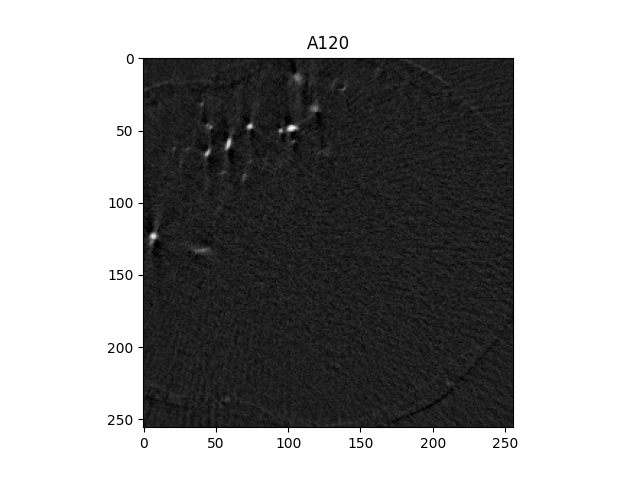

In [13]:
case = 'A120'
figure, slider = plot3d(data_path, case, vis_pred=False)
slider

### Visualize mesh

In [11]:
import pyvista as pv

In [12]:
# create a mesh and identify some scalars you wish to plot
mesh = pv.read(data_path / '{}.stl'.format(case))
z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=True)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [13]:
# create a mesh and identify some scalars you wish to plot
mesh = pv.read(data_path / '{}_vessel.stl'.format(case))
z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=True)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Dataset + dataloader

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
class AeurysmDataset(Dataset):
    """Aneurysm dataset."""

    def __init__(self, data_path, cases, transform=None, image_size=(256, 256, 220)):
        
        self.data_path = data_path
        self.cases = cases
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.cases)
    
    def __load_image(self, case):
        # load NIFTI image
        image_nib = nib.load(self.data_path / '{}_orig.nii.gz'.format(case))
        return image_nib.get_fdata()
        
    def __load_mask(self, case):
        # load NIFTI mask
        mask_nib = nib.load(self.data_path / '{}_masks.nii.gz'.format(case))
        return mask_nib.get_fdata()

    def __getitem__(self, idx):
        
        # load image and ground-truth
        case = self.cases[idx]
        image = self.__load_image(case)[:self.image_size[0], :self.image_size[1], :self.image_size[2]]
        mask = self.__load_mask(case)[:self.image_size[0], :self.image_size[1], :self.image_size[2]]
        
        # data augmentation
        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        
        return sample['image'], sample['mask']

In [16]:
# get case names
cases = list(map(lambda file: '_'.join(file.parts[-1].split('_')[:-1]), data_path.glob('*_orig.nii.gz')))

# create dataset + dataloader
aneurysm_dataset = AeurysmDataset(data_path, cases[:10])
dataloader = DataLoader(
    aneurysm_dataset, 
    batch_size=2,
    shuffle=True, 
    num_workers=0
)

### Model

In [17]:
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCELoss

#
from tqdm.notebook import tqdm, trange

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.Sigmoid(),
        )

    def __call__(self, x):
        return self.conv1(x)

In [19]:
# create a simple cnn instance
model = SimpleCNN().cuda()

# create Adam optimizer with standard parameters
optimizer = Adam(params=model.parameters())

# binary cross entropy loss
loss_fx = BCELoss()

In [20]:
epochs = 10
losses = []
for epoch in trange(epochs):
    
    # iterate dataloader
    epoch_loss = []
    for image, mask in dataloader:
    
        #
        _, h, w, _ = image.shape
        image_slices = image.permute(0, 3, 1, 2).reshape(-1, h, w).float().cuda()
        image_slices = torch.unsqueeze(image_slices, axis=1)
        mask_slices = mask.permute(0, 3, 1, 2).reshape(-1, h, w).float().cuda()
        
        # reset gradient
        optimizer.zero_grad()
        
        # pass input through model
        output = model(image_slices)
        output = torch.squeeze(output)
        
        # calculate loss
        loss = loss_fx(output, mask_slices)
        epoch_loss.append(loss.detach().item())
        
        # back-propagation
        loss.backward()
        optimizer.step()
        
    #
    losses.append(np.mean(epoch_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
fig = plt.figure()

#
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### View model predictions

In [ ]:
# get first batch from dataloader
image, mask = next(iter(dataloader))

# transpose data
_, h, w, _ = image.shape
image_slices = image.permute(0, 3, 1, 2).reshape(-1, h, w).float()
image_slices = torch.unsqueeze(image_slices, axis=1)
mask_slices = mask.permute(0, 3, 1, 2).reshape(-1, h, w).float()

# model prediction
with torch.no_grad():
    outputs = model(image_slices.cuda())
    outputs = torch.squeeze(outputs)
    
# convert to numpy
image_np = torch.squeeze(image_slices).numpy()
ground_truth_np = mask_slices.numpy()
prediction_np = outputs.cpu().numpy()

In [ ]:
# TODO: visualize predictions